## Human tracking and counting

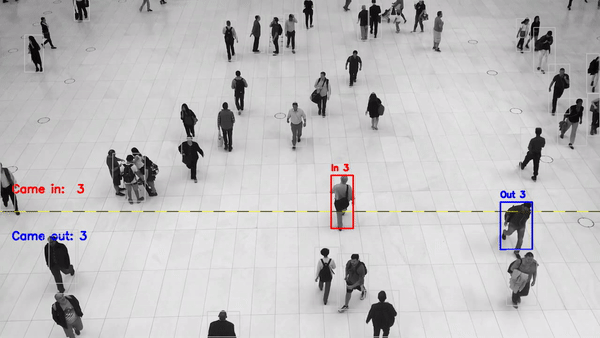

This notebook demonstrates people detection on the video from cctv camera with tracking and counting of incoming and outcoming persons in shopping mall.

Video source: [**pixabay.com**](https://pixabay.com/videos/people-commerce-shop-busy-mall-6387/)<br>
You can view the final video [**here**](https://disk.yandex.ru/d/eqShcDwQM15Xgg) 

#### The algorithm
* Take every single frame from video stream
* Pass taken frame through pre-trained YOLO network and get bboxes of detected people
* Compare bbox center coordinates with coordinates from previous frame
* Calculate euclidian distance for each pair of previous and current coordinates
* If calculated distance is small, highly likely this pair of coordinates belong to the same person
* If some new coordinate founed, add this coordinates to the database
* If some person is not seen for more than 5 frames, remove this person from the database
* If any person's Y coordinate is crossing the border line, this person is marked as incoming or outcoming respectively
* All such persons are highlighted by color (blur or red) bboxes for 1 second after crossing the line

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import time

#### First frame

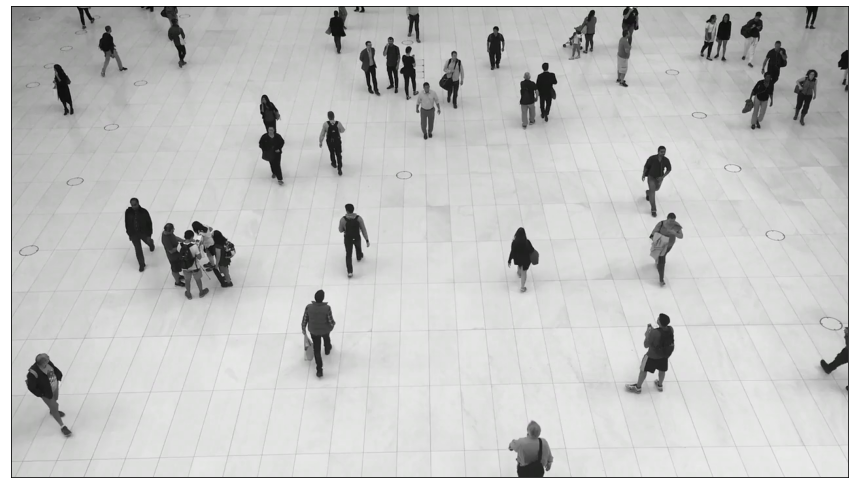

In [2]:
stream = cv2.VideoCapture('../input/onastreet/People - 6387.mp4')
frame = stream.read()[1]
template = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (15, 15))
plt.xticks([]), plt.yticks([])
plt.imshow(template)
plt.show()

#### Constants and paths

In [3]:
# Border line Y coordinate
Y_border   = 450

# Start value for person ID counter
Last_ID    = 0

# Start values for "crossed" persons ID counters
went_UP    = 0
went_DOWN  = 0

# YOLO confidence threshold
YOLO_thres = 0.8

# Non-maxima supression threshold
NMS_thres = 0.2

# Pre-trained YOLO paths
weightsPath = '../input/onastreet/yolov3.weights'
configPath = '../input/onastreet/yolov3.cfg'

# Random seed
np.random.seed(17)

#### Yolo loading and parameters initiation

In [4]:
# Get pretrained network
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

# Get list of unconnected layers
ln = net.getLayerNames()
ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

def yolo (image):
    '''Get bounding boxes only for interested class - persons (ClassID == 0)'''
    
    (H, W) = image.shape[:2]

    # Preprocess image
    blob = cv2.dnn.blobFromImage(image,
                                 1 / 255.0,
                                 (416, 416),
                                 swapRB = True,
                                 crop = False)
    
    # Pass image through the network
    net.setInput(blob)
    layerOutputs = net.forward(ln)
    
    boxes, confidences, classIDs = [], [], []
    
    # Filter boinding boxes
    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            if (confidence > YOLO_thres) & (classID == 0):
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                x = int(centerX - (width  / 2))
                y = int(centerY - (height / 2))

                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)
            
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, confidence,	NMS_thres)
    bboxes = np.take(boxes, idxs, axis=0)
    
    return bboxes

### Coordinates module

In [5]:
class Stat:
    '''
    This module is responsible for processing
    the coordinates received from YOLO for each frame
    '''
    
    

    '''Database template'''
    cols = [
        'ID',            # ID for ordinary persons
        'new_ID',        # ID for "crossed" persons
        'Xc', 'Yc',      # Bbox center
        'x','y','w','h', # Bbox coordinates and sizes
        'unseen',        # Unseen counter
        'status']        # Counter to highlight crossed persons
    db_template = pd.DataFrame(columns = cols)
    

    def __init__(self, db):
        self.db = db
        return

    
    def register(self, center):
        '''Register new persons'''
        
        global Last_ID
        
        # Create new record
        new_record = pd.DataFrame(columns = Stat.cols)
        new_record.loc[0, 'ID'] = Last_ID
        new_record.loc[0, ['Xc', 'Yc', 'x', 'y', 'w', 'h']] = center
        new_record.loc[0, 'status'] = 0
        new_record.loc[0, 'unseen'] = 0
        
        # Increase ID counter
        Last_ID += 1
        
        # Append new record do the database
        self.db = self.db.append(new_record).reset_index(drop = True)
        return
    
    
    
    @staticmethod
    def get_centers(boxes):
        '''Get centers of bboxes detected by YOLO'''
        
        centers = np.empty((len(boxes), 6), np.int16)
        for i in range(len(boxes)):
            x = boxes[i][0]
            y = boxes[i][1]
            w = boxes[i][2]
            h = boxes[i][3]

            Xc = x + w // 2 
            Yc = y + h // 2

            centers[i] = np.array([Xc, Yc, x, y, w, h])

        return centers 
    

    
    @staticmethod
    def euc(x1, y1, x2, y2):
        '''Euclidian distance calculation'''
        
        dist = (x1-x2)**2 + (y1-y2)**2
        dist = int(np.sqrt(dist))
        return dist  
    
    

    def update(self, centers, thrs):
        '''Check and update coordinates of every person on a frame'''
        
        db = self.db
        
        global went_UP, went_DOWN
        
        # If database is emtpy (i.e. for the first frame)
        # register all persons and return
        
        if (len(db) == 0):
            for i in range(len(centers)):
                Stat.register(self, centers[i])
            return

        confirmed = []
        
        # Compare all detected bboxes with all known persons
        for i in range(len(db)):
            for j in range(len(centers)):
                
                # Calculate euclidian distance for each pair
                distance = Stat.euc (db.loc[i,'Xc'], db.loc[i,'Yc'],
                                    centers[j,0], centers[j,1])

                # If distance is less than threshold
                if distance <= thrs:
                    
                    #Check if somebody cross the line in UP direction
                    if (db.loc[i,'Yc'] >= Y_border) and (centers[j,1] < Y_border):
                        
                        # Change status to minimum positive
                        db.loc[i,'status'] = 1
                        # Encount as 'Came IN'
                        went_UP += 1
                        # Assign new ID
                        db.loc[i,'new_ID'] = 'In ' + str(went_UP)

                    # The same for another direction
                    if (db.loc[i,'Yc'] < Y_border) and (centers[j,1] >= Y_border):
                        db.loc[i,'status'] = -1
                        went_DOWN += 1
                        db.loc[i,'new_ID'] = 'Out ' + str(went_DOWN)

                    # Update coordinate database
                    db.loc[i, ['Xc', 'Yc', 'x', 'y', 'w', 'h']] = centers[j]
                    
                    # Remove detected coordinates in order not to check it again
                    # Finally only newly detected persons will stay in the `centers` array
                    centers = np.delete(centers, j, axis = 0)
                    
                    # Add person ID to the list of confirmed persons
                    confirmed.append(db.loc[i, 'ID'])
                    
                    # Stop looping and continue with next detected box
                    break
        
        # When looping is over:
        # 
        # Increase counter for unseen persons
        db.loc[~db.ID.isin(confirmed), 'unseen'] += 1

        # Unregister persons who unseen > 10 frames
        db = db[db.unseen <= 5].reset_index(drop = True)

        # Increase indication counter for "crossed" persons
        db.status[db.status > 0] += 1
        db.status[db.status < 0] -= 1

        self.db = db
        
        # Register new persons
        for i in range(len(centers)):
            Stat.register(self, centers[i])

        return

### Drawing module

In [6]:
class Draw:
    '''
    This module is responsible for drawing on each frame
    '''
    
    def __init__(self, frame):
        self.frame = frame
        return

    # Colors to highlight crossing persons
    colors = { 1 : (255, 0, 0),
               0 : (0,   0, 255)}


    def line(self):
        '''This method is drawing animated line'''

        # Static yellow background
        cv2.line(self.frame,
                 (0, Y_border),
                 (frame.shape[1], Y_border),
                 color = (0, 255, 255),
                 thickness=1,
                 lineType = cv2.LINE_AA)
        
        # Moving black foreground
        for i in range (self.frame.shape[1] // 50 + 1):
            move = counter % 10
            x = i*50 + move * 50 // 10
            l = 25
            cv2.line(self.frame,
                     (x,     Y_border),
                     (x + l, Y_border),
                     color = 0,
                     thickness = 1,
                     lineType  = cv2.LINE_AA)
        return       
    
    def text (self, db):
        '''Put static text with came IN / OUT counters'''
        
        #Text message
        text = ['Came in:  '+ str(went_UP),
                'Came out: '+ str(went_DOWN)] 

        # Putting text in two lines
        for i, txt in enumerate(text):
            cv2.putText(self.frame,
                        txt, 
                        org = (25, Y_border - 50 + (i * 100) + 10),
                        fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale = 0.8,
                        color = Draw.colors.get(i),
                        thickness = 2,
                        lineType=cv2.LINE_AA)
        return
    
    def persons(self, db):
        '''
        - Draw light bboxes for non crossing persons
        - Draw red / blue bboxes for came IN / OUT persons
          -- Crossed persons must be highlithed for 1 second (20 frames) 
        - Bbox lines thickness is reducing from 3 to 1 continiously
        - Put new ID for crossed persons
        '''
        
        # Get coordinates from given database
        for i in range(len(db)):
            ID = db.loc[i,'ID']
            x  = db.loc[i,'x']
            y  = db.loc[i,'y']
            w  = db.loc[i,'w']
            h  = db.loc[i,'h']
            s  = db.loc[i,'status']
            new_ID  = db.loc[i,'new_ID']

        
        # Bbox and text parameters defenition
        #
        # Color bboxes for crossed persons
            if 0 < abs(s) <= 20:
                color = Draw.colors.get(s < 0)
                bbox_thickness = 3 - abs(s) // 10
                
                cv2.putText(self.frame,
                            new_ID, 
                            org = (x, y - 10),
                            fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                            fontScale = 0.6,
                            color = color,
                            thickness = 2,
                            lineType=cv2.LINE_AA)
        
        # Light bboxes and no ID for persons who didn't crossed the line
            else:
                color = (200, 200, 200)
                bbox_thickness = 1

        # Draw bboxes for all persons but with different color and thickness
            cv2.rectangle(self.frame,
                          (x,y),
                          (x+w, y+h),
                          color = color,
                          thickness = bbox_thickness,
                          lineType=cv2.LINE_AA)
        return

### Video read & write

In [7]:
%%time

# Video reader and writer initiation
stream       = cv2.VideoCapture('../input/onastreet/People - 6387.mp4')
fourcc       = cv2.VideoWriter_fourcc(*"MJPG")
out          = cv2.VideoWriter('output.avi',
                               fourcc,
                               20.0,
                               (template.shape[1],template.shape[0]))

# Database initiation
coord = Stat(db = Stat.db_template)

# Start reading video stream
while True:

    # Take next frame
    frame = stream.read()[1]
    
    # Frames counter
    counter = int(stream.get(cv2.CAP_PROP_POS_FRAMES))
    
    # Stop if video stream is over
    if frame is None:
        break
    
  
    # Get bboxes from yolo
    boxes  = yolo(frame)
    # Get bbox centers
    centers = coord.get_centers(boxes)
    
    # Update coordinate database
    coord.update(centers, thrs = 10)
    
    # Frame clone initiation
    draw = Draw(frame)
    # Draw animated border line
    draw.line()
    # Draw static text with counters
    draw.text(coord.db)
    # Draw bboxes and ID (for 'crossed' persons)
    draw.persons(coord.db)
    
    # Write frame with drawing
    out.write(draw.frame)
  
    # Delete frame
    del draw
    
# Release output
out.release()

print ('Complete')

Complete
CPU times: user 13min 7s, sys: 19.7 s, total: 13min 26s
Wall time: 3min 57s


#### Thank you for your attention !